### Step1: crop cells region by region

similar to seqscope's step4\
start from this step becuase stereoseq data is large, so early steps are not included, also becuase stereoseq image and ST data are already aligned

**note**, need to manually change which region working on\
**note**, dd=5, centers detected are all 5 units away from cell boundary

In [30]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pickle
import cv2
from collections import defaultdict
import timeit
# pd.options.mode.chained_assignment = None  # default='warn'

In [5]:
##### specify region index
# regions
# 1 image[26000:33000,9500:18000] | 2 image[26000:33000,18000:26460]
# 3 image[19000:26000,9500:18000] | 4 image[19000:26000,18000:26460]
# 5 image[12000:19000,9500:18000] | 6 image[12000:19000,18000:26460]
# 7 image[5500:12000,9500:18000]  | 8 image[5500:12000,18000:26460]

r = 1        # <<<<<
rx1 = 26000  # <<<<<
rx2 = 33000  # <<<<<
ry1 = 9500   # <<<<<
ry2 = 18000  # <<<<<

print(f'===== working on region r={r}\n')

working on region r=1


In [4]:
##### load cellpose segmentation
print('===== read data:\n')

filename = '../input/R'+str(r)+'_seg.npy'
dat = np.load(filename, allow_pickle=True).item()
print(dat.keys())
print('img', dat['img'].shape)
print('outlines', dat['outlines'].shape)
print('masks', dat['masks'].shape, np.amin(dat['masks']), np.amax(dat['masks']))

dict_keys(['img', 'outlines', 'masks', 'chan_choose', 'ismanual', 'filename', 'flows', 'est_diam'])
img (7000, 8500)
outlines (7000, 8500)
masks (7000, 8500) 0 74777


In [9]:
##### read bin1 data provided by stereoseq
filename = '../input/E16.5_E1S3_GEM_bin1.pkl'
with open(filename, 'rb') as f:
    pickle_dict = pickle.load(f)
bin1_ = pickle_dict['bin1_df']
print(bin1_.head())
bin1 = bin1_.rename({'MIDCount': 'umi'}, axis=1)
print(bin1.head())

  geneID      x      y  MIDCount
0    Cr2  16118  19912         1
1    Cr2  13889  19182         1
2    Cr2  24801  25748         1
3    Cr2  15273  24153         1
4    Cr2  11997  15366         1
  geneID      x      y  umi
0    Cr2  16118  19912    1
1    Cr2  13889  19182    1
2    Cr2  24801  25748    1
3    Cr2  15273  24153    1
4    Cr2  11997  15366    1


In [12]:
##### read unsp data (un-processed)
filename = '../input/unsp_df_dict.pkl'
with open(filename, 'rb') as f:
    pickle_dict = pickle.load(f)
unsp_ = pickle_dict['unsp_df']
print(unsp_.head())
# switch x y
unsp2_ = unsp_.rename({'x': 'y', 'y': 'x'}, axis=1)
print(unsp2_.head())
# groupby coord
unsp = unsp2_.groupby(['x', 'y']).sum().reset_index()
print(unsp.head())

         x        y  umi
0  22269.0  14803.0    1
1  22331.0   7932.0    1
2  26290.0  23043.0    1
3  18736.0  27304.0    3
4  17801.0  13529.0    2
         y        x  umi
0  22269.0  14803.0    1
1  22331.0   7932.0    1
2  26290.0  23043.0    1
3  18736.0  27304.0    3
4  17801.0  13529.0    2
      x        y  umi
0   2.0    623.0    2
1   5.0  25469.0    1
2   6.0  23943.0    1
3   8.0  10990.0    6
4  10.0   4595.0    2


In [13]:
##### read sp data (un-processed)
filename = '../input/sp_df_dict.pkl'
with open(filename, 'rb') as f:
    pickle_dict = pickle.load(f)
sp_ = pickle_dict['sp_df']
print(sp_.head())
# switch x y
sp2_ = sp_.rename({'x': 'y', 'y': 'x'}, axis=1).copy()
print(sp2_.head())
# groupby coord
sp = sp2_.groupby(['x', 'y']).sum().reset_index().copy()
print(sp.head())

         x        y  umi
0  13509.0  28563.0    1
1  22331.0   7932.0    1
2  18602.0  15959.0    2
3  20770.0  26462.0    1
4  10880.0  21763.0    1
         y        x  umi
0  13509.0  28563.0    1
1  22331.0   7932.0    1
2  18602.0  15959.0    2
3  20770.0  26462.0    1
4  10880.0  21763.0    1
     x        y  umi
0  0.0  14690.0    8
1  0.0  18850.0    1
2  1.0   9194.0    1
3  1.0  19349.0    4
4  2.0   4038.0    1


In [14]:
##### get bin1, unsp, sp on the region
# bin1_r - region
filter1 = bin1.x >= rx1
filter2 = bin1.x < rx2
filter3 = bin1.y >= ry1
filter4 = bin1.y < ry2
bin1_r = bin1[filter1 & filter2 & filter3 & filter4]
bin1_r['xr'] = bin1_r.x.copy() - rx1 # relative coord on region (matched with seg mask)
bin1_r['yr'] = bin1_r.y.copy() - ry1
print(bin1_r.head())

# unsp_r - region
filter1 = unsp.x >= rx1
filter2 = unsp.x < rx2
filter3 = unsp.y >= ry1
filter4 = unsp.y < ry2
unsp_r = unsp[filter1 & filter2 & filter3 & filter4]
unsp_r['xr'] = unsp_r.x.copy() - rx1 # relative coord on region (matched with seg mask)
unsp_r['yr'] = unsp_r.y.copy() - ry1
print(unsp_r.head())

# sp_r - region
filter1 = sp.x >= rx1
filter2 = sp.x < rx2
filter3 = sp.y >= ry1
filter4 = sp.y < ry2
sp_r = sp[filter1 & filter2 & filter3 & filter4].copy()
sp_r['xr'] = sp_r.x.copy() - rx1 # relative coord on region (matched with seg mask)
sp_r['yr'] = sp_r.y.copy() - ry1
print(sp_r.head())

/tmp/ipykernel_25985/2840753512.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bin1_r['xr'] = bin1_r.x.copy() - rx1 # relative coord on region (matched with seg mask)
/tmp/ipykernel_25985/2840753512.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bin1_r['yr'] = bin1_r.y.copy() - ry1


   geneID      x      y  umi    xr    yr
12   Cr1l  26717  13204    1   717  3704
22   Cr1l  27415  13928    1  1415  4428
32   Cr1l  28282  14437    1  2282  4937
40   Cr1l  31304  15196    1  5304  5696
43   Cr1l  27810  14932    1  1810  5432


/tmp/ipykernel_25985/2840753512.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unsp_r['xr'] = unsp_r.x.copy() - rx1 # relative coord on region (matched with seg mask)
/tmp/ipykernel_25985/2840753512.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unsp_r['yr'] = unsp_r.y.copy() - ry1


                x       y  umi   xr     yr
33045320  26000.0  9514.0    1  0.0   14.0
33045321  26000.0  9559.0    3  0.0   59.0
33045322  26000.0  9599.0    2  0.0   99.0
33045323  26000.0  9606.0    1  0.0  106.0
33045324  26000.0  9781.0    1  0.0  281.0
                 x       y  umi   xr    yr
134515366  26000.0  9507.0   12  0.0   7.0
134515367  26000.0  9508.0    2  0.0   8.0
134515368  26000.0  9519.0    5  0.0  19.0
134515369  26000.0  9521.0    1  0.0  21.0
134515370  26000.0  9524.0    2  0.0  24.0


In [19]:
##### compute unspMat_r, spMat_r on the region

# kernal size
kn = 10 # <<<<<
# circle kernal for computing local density
kernalCir = np.zeros((kn,kn))
for i in range(kn):
    for j in range(kn):
        if (i-int(kn/2)-1)*(i-int(kn/2)-1) + (j-int(kn/2)-1)*(j-int(kn/2)-1) < kn*kn/4:
            kernalCir[i,j] = 1

start = timeit.default_timer()

# unsp matrix
unspMat_r = np.zeros((int(unsp_r.xr.max()), int(unsp_r.yr.max())), dtype=int)
print(unspMat_r.shape)
# compute unspMat
for i in range(unsp_r.xr.size):
    if i % 1e5 == 0:
        sys.stdout.write('' * 50 + '\r' + str(i/unsp_r.xr.size)) # percentage progress
        sys.stdout.flush()
    xi = unsp_r.xr.iloc[i]
    yi = unsp_r.yr.iloc[i]
    try:
        unspMat_r[int(xi-kn/2):int(xi+kn/2), int(yi-kn/2):int(yi+kn/2)] = unspMat_r[int(xi-kn/2):int(xi+kn/2), int(yi-kn/2):int(yi+kn/2)] + unsp_r.umi.iloc[i]*kernalCir
    except:
        pass

# sp matrix
spMat_r = np.zeros((int(sp_r.xr.max()), int(sp_r.yr.max())), dtype=int)
print(spMat_r.shape)
# compute spMat
for i in range(sp_r.xr.size):
    if i % 1e5 == 0:
        sys.stdout.write('' * 50 + '\r' + str(i/sp_r.xr.size)) # percentage progress
        sys.stdout.flush()
    xi = sp_r.xr.iloc[i]
    yi = sp_r.yr.iloc[i]
    try:
        spMat_r[int(xi-kn/2):int(xi+kn/2), int(yi-kn/2):int(yi+kn/2)] = spMat_r[int(xi-kn/2):int(xi+kn/2), int(yi-kn/2):int(yi+kn/2)] + sp_r.umi.iloc[i]*kernalCir
    except:
        pass

stop = timeit.default_timer()
print('\n Time: ', stop - start) # ~948s

(6999, 8499)
0.997926553013015236(6999, 8499)
0.995389575619961434
 Time:  948.5365449003875


In [46]:
##### check if dim match
print(dat['img'].shape)
print(unsp_r.xr.max()+1, unsp_r.yr.max()+1)

(7000, 8500)
7000.0 8500.0


In [47]:
##### find cell label for bin1_r and unsp_r
print('===== find cell label:\n')

# mask
mask_r = dat['masks']

# find cell label for bin1_r
start = timeit.default_timer()
label = []
for i in range(len(bin1_r)):
    l = mask_r[int(bin1_r['xr'].iloc[i]), int(bin1_r['yr'].iloc[i])]
    label.append(l)
stop = timeit.default_timer()
print('Time: ', stop - start) # ~792s
# append label to bin1_r
bin1_r['cell'] = np.array(label)
print(bin1_r.head())
# remove unlabled cell (cell=0)
bin1_seg_r = bin1_r[bin1_r.cell>0]
print(bin1_seg_r.head())

# find cell label for unsp_r
start = timeit.default_timer()
label = []
for i in range(len(unsp_r)):
    l = mask_r[int(unsp_r['xr'].iloc[i]), int(unsp_r['yr'].iloc[i])]
    label.append(l)
stop = timeit.default_timer()
print('Time: ', stop - start) # ~62s
# append label to bin1_r
unsp_r['cell'] = np.array(label)
print(unsp_r.head())
# remove unlabled cell (cell=0)
unsp_seg_r = unsp_r[unsp_r.cell>0]
print(unsp_seg_r.head())

===== find cell label:

Time:  781.8313245577738
   geneID      x      y  umi    xr    yr   cell
12   Cr1l  26717  13204    1   717  3704  12014
22   Cr1l  27415  13928    1  1415  4428      0
32   Cr1l  28282  14437    1  2282  4937  35736
40   Cr1l  31304  15196    1  5304  5696  69899
43   Cr1l  27810  14932    1  1810  5432      0


/tmp/ipykernel_25985/181365738.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bin1_r['cell'] = np.array(label)


    geneID      x      y  umi    xr    yr   cell
12    Cr1l  26717  13204    1   717  3704  12014
32    Cr1l  28282  14437    1  2282  4937  35736
40    Cr1l  31304  15196    1  5304  5696  69899
71    Cr1l  27765  14317    2  1765  4817  27658
140   Cr1l  29228  15955    1  3228  6455  49512
Time:  63.08038371242583
                x       y  umi   xr     yr  cell
33045320  26000.0  9514.0    1  0.0   14.0     0
33045321  26000.0  9559.0    3  0.0   59.0     0
33045322  26000.0  9599.0    2  0.0   99.0     0
33045323  26000.0  9606.0    1  0.0  106.0     0
33045324  26000.0  9781.0    1  0.0  281.0     0
                x        y  umi   xr     yr  cell
33045347  26000.0  10070.0    2  0.0  570.0     1
33045348  26000.0  10071.0    2  0.0  571.0     1
33045349  26000.0  10072.0    3  0.0  572.0     1
33045351  26000.0  10135.0    1  0.0  635.0     2
33045352  26000.0  10138.0    2  0.0  638.0     2


/tmp/ipykernel_25985/181365738.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unsp_r['cell'] = np.array(label)


In [48]:
##### find cell center with unsp_seg_r
print('===== find cell center:\n')

# min dis from center to boundary
# feasible domain for maxima search as cell center
dd = 5 # <<<<<
print('dd='+str(dd))

crop_cell_buffer_distance = 5 # croping a larger region than the actual cell region to avoid potential error
npad = 1 # padding width in a intermidate step
erosion_kernel = np.ones((2*dd+1, 2*dd+1), np.uint8) # erosion kernal 

bin1_seg_r_gbC = bin1_seg_r.groupby('cell')
cellUnique = unsp_seg_r.cell.unique().tolist()

start = timeit.default_timer()

centers = [] # unsp centers
for i, c in enumerate(cellUnique):
    if i % 1e3 == 0:
        sys.stdout.write('' * 50 + '\r' + str(i/len(cellUnique))) # percentage progress
        sys.stdout.flush()
    try:
        bin1_seg_r_c = bin1_seg_r_gbC.get_group(c).copy()
        xmin_ = bin1_seg_r_c.xr.min()
        xmax_ = bin1_seg_r_c.xr.max()
        ymin_ = bin1_seg_r_c.yr.min()
        ymax_ = bin1_seg_r_c.yr.max()

        unspMat_r_c = unspMat_r[(xmin_-crop_cell_buffer_distance):(xmax_+crop_cell_buffer_distance), (ymin_-crop_cell_buffer_distance):(ymax_+crop_cell_buffer_distance)]
        mask_r_c = mask_r[(xmin_-crop_cell_buffer_distance):(xmax_+crop_cell_buffer_distance), (ymin_-crop_cell_buffer_distance):(ymax_+crop_cell_buffer_distance)]

        # process mask_t_c
        mask_r_c_binary = (mask_r_c == c).astype(np.uint8) # binary mask
        mask_r_c_binary_padded = np.pad(mask_r_c_binary, npad, mode='constant') # pad for better erosion
        mask_r_c_binary_padded_erosion = cv2.erode(mask_r_c_binary_padded, erosion_kernel, iterations=1) # erosion
        mask_r_c_binary_padded_erosion_depadded = mask_r_c_binary_padded_erosion[npad:-npad,npad:-npad] # remove padding

        # keep unspliced density within the desired area, and looking for maximum
        unspmask_r_c = unspMat_r_c*mask_r_c_binary_padded_erosion_depadded
        center_c = np.where(unspmask_r_c == unspmask_r_c.max())
        center_c2 = [round(np.mean(center_c[0])+(xmin_-crop_cell_buffer_distance)), round(np.mean(center_c[1])+(ymin_-crop_cell_buffer_distance))]

        # save detected center, cell label, and unspliced density value at center
        centers.append([center_c2[0], center_c2[1], c, unspmask_r_c.max()])

        unspmask_r_c = unspMat_r_c*(mask_r_c == c)
    except:
        centers.append([0,0,c,0])  
stop = timeit.default_timer()
print('Time: ', stop - start) 
print('#centers', len(centers)) # ~57s
centers_bkp = centers

===== find cell center:

dd=5
0.993115295317595635Time:  61.283567409962416
#centers 74513


In [49]:
##### keep cells with unspMat[center] > q1
q1=np.quantile(unspMat_r, 0.95) # <<<<<
print('q1 =', q1)
centers1 = np.array(centers)[np.array(centers)[:,3] >= q1,:]
print(centers1.shape)

q1 = 74.0
(12986, 4)


In [50]:
##### keep cells with spMat[center] < q2
q2=np.quantile(spMat_r, 0.95)
print('q2 =', q2)
centers2 = []
for i in range(centers1.shape[0]):
    if spMat_r[centers1[i,0], centers1[i,1]] <= q2:
        centers2.append(centers1[i,:])
centers2 = np.array(centers2)
print(centers2.shape)

q2 = 319.0
(12584, 4)


In [51]:
##### append cell centers to bin1_seg_r
# bin1_seg_r
data = bin1_seg_r['cell'].tolist()
keys = np.array(centers2)[:,2]
vals = np.array(centers2)[:,:2]
memo = defaultdict(lambda: (0, 0))
for k, v in zip(keys, vals):
    if k not in memo:
        memo[k] = v
    else:
        raise ValueError('duplicated keys')

res0 = list(map(lambda x: memo[x][0], data))
res1 = list(map(lambda x: memo[x][1], data))

print(len(res0), len(data), len(keys), len(vals))

bin1_seg_r['centerX_r'] = np.array(res0)
bin1_seg_r['centerY_r'] = np.array(res1)
print(bin1_seg_r.head())

bin1_seg_r = bin1_seg_r[(bin1_seg_r.centerX_r>0) & (bin1_seg_r.centerY_r>0)].copy()

bin1_seg_r['centerX'] = bin1_seg_r['centerX_r'].copy() + rx1
bin1_seg_r['centerY'] = bin1_seg_r['centerY_r'].copy() + ry1
print(bin1_seg_r.head())

29303239 29303239 12584 12584


/tmp/ipykernel_25985/4070195005.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bin1_seg_r['centerX_r'] = np.array(res0)
/tmp/ipykernel_25985/4070195005.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bin1_seg_r['centerY_r'] = np.array(res1)


    geneID      x      y  umi    xr    yr   cell  centerX_r  centerY_r
12    Cr1l  26717  13204    1   717  3704  12014        712       3700
32    Cr1l  28282  14437    1  2282  4937  35736       2291       4944
40    Cr1l  31304  15196    1  5304  5696  69899          0          0
71    Cr1l  27765  14317    2  1765  4817  27658          0          0
140   Cr1l  29228  15955    1  3228  6455  49512       3234       6442
    geneID      x      y  umi    xr    yr   cell  centerX_r  centerY_r  \
12    Cr1l  26717  13204    1   717  3704  12014        712       3700   
32    Cr1l  28282  14437    1  2282  4937  35736       2291       4944   
140   Cr1l  29228  15955    1  3228  6455  49512       3234       6442   
454   Cr1l  28116  13051    1  2116  3551  33156       2114       3556   
459   Cr1l  26934  12445    1   934  2945  15337        946       2941   

     centerX  centerY  
12     26712    13200  
32     28291    14444  
140    29234    15942  
454    28114    13056  
459    26

===== viz overlay:



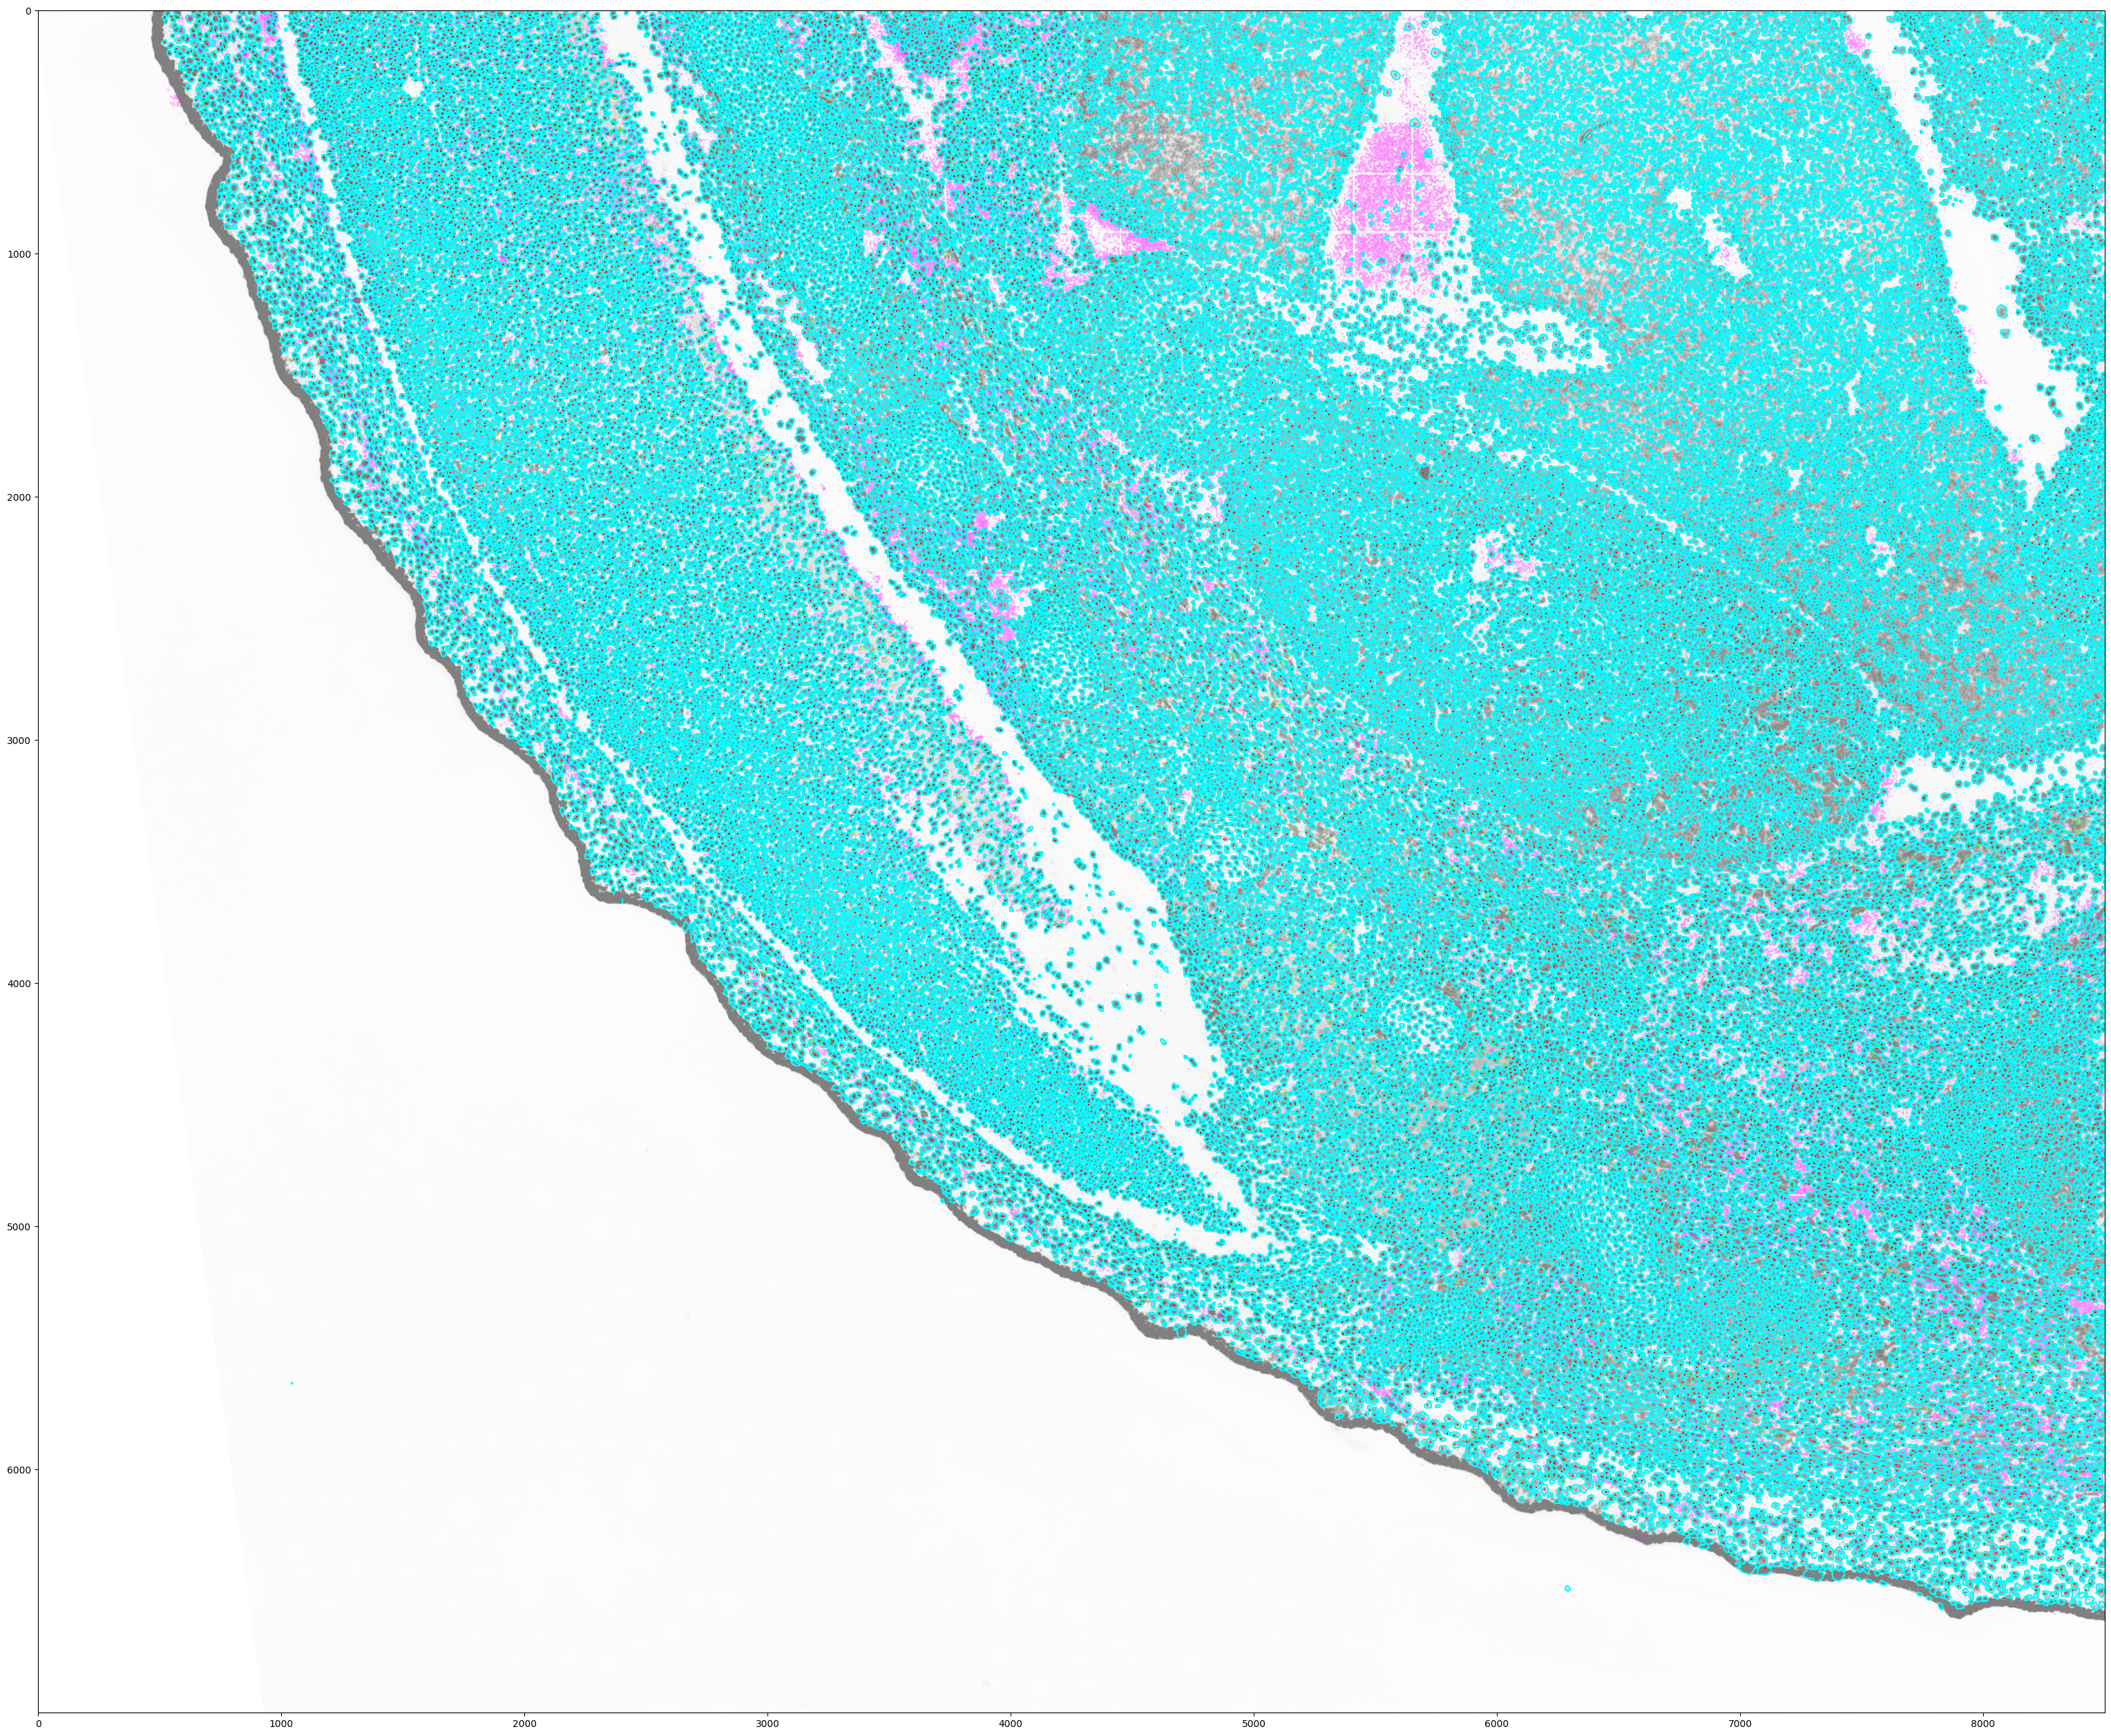

In [52]:
##### viz overlay
print('===== viz overlay:\n')

##### define alpha colormaps
try:
    # black alpha
    color_array = np.zeros([10,4])
    color_array[:,-1] = np.linspace(0,0.1,10)
    map_object = colors.LinearSegmentedColormap.from_list(name='black_alpha', colors=color_array)
    plt.register_cmap(cmap=map_object)
    # red alpha
    color_array = np.zeros([10,4])
    color_array[:,0] = 1
    color_array[:,-1] = np.linspace(0,1,10)
    map_object = colors.LinearSegmentedColormap.from_list(name='red_alpha', colors=color_array)
    plt.register_cmap(cmap=map_object)
    # green alpha
    color_array = np.zeros([10,4])
    color_array[:,1] = 1
    color_array[:,-1] = np.linspace(0,1,10)
    map_object = colors.LinearSegmentedColormap.from_list(name='green_alpha', colors=color_array)
    plt.register_cmap(cmap=map_object)
    # blue alpha
    color_array = np.zeros([10,4])
    color_array[:,1] = 1
    color_array[:,2] = 1
    color_array[:,-1] = np.linspace(0,1,10)
    map_object = colors.LinearSegmentedColormap.from_list(name='blue_alpha', colors=color_array)
    plt.register_cmap(cmap=map_object)
    # pink alpha
    color_array = np.zeros([10,4])
    color_array[:,0] = 1
    color_array[:,2] = 1
    color_array[:,-1] = np.linspace(0,1,10)
    map_object = colors.LinearSegmentedColormap.from_list(name='pink_alpha', colors=color_array)
    plt.register_cmap(cmap=map_object)
    # orange alpha
    color_array = np.zeros([10,4])
    color_array[:,0] = 1
    color_array[:,1] = 0.39
    color_array[:,2] = 0.28
    color_array[:,-1] = np.linspace(0,1,10)
    map_object = colors.LinearSegmentedColormap.from_list(name='orange_alpha', colors=color_array)
    plt.register_cmap(cmap=map_object)
except:
    pass

fig, ax = plt.subplots(1,1, figsize=(40,32))
# image
ax.imshow(dat['img'],
          cmap='Greys',
          alpha=0.5,
          origin='upper')

# bin1_r
# ax.scatter(bin1_r.yr,
#            bin1_r.xr,
#            c=bin1_r.umi,
#            s=1,
#            vmin=0,
#            vmax=bin1_r.umi.quantile(.9999),
#            cmap = 'pink_alpha',
#            alpha=0.1,
#            marker='.')

# sp_r
ax.imshow(spMat_r*(spMat_r>q2),
#           vmin=0,
#           vmax=np.quantile(spMat_r, 0.9),
          cmap='pink_alpha',
          alpha=1,
          origin='upper')

# unsp_r
# ax.scatter(unsp_r.yr,
#            unsp_r.xr,
#            c=unsp_r.umi,
#            s=1,
#            vmin=0,
#            vmax=unsp_r.umi.quantile(.9),
#            cmap = 'green_alpha',
#            alpha=0.8,
#            marker='.')
ax.imshow(unspMat_r*(unspMat_r>q1),
#           vmin=0,
#           vmax=np.quantile(unspMat_r, 0.9),
          cmap='green_alpha',
          alpha=1,
          origin='upper')

# seg
ax.imshow(dat['outlines'],
          vmin=0,
          vmax=2,
          cmap='blue_alpha',
          origin='upper')

c_arr = np.array(centers2)
ax.scatter(c_arr[:,1],
           c_arr[:,0],
           c='red',
           marker='+',
           s=2)

ax.set_aspect('equal', adjustable='box')
ax.grid(False)
fig.savefig('../output_fig/step1_R'+str(r)+'.pdf', dpi=200)

In [53]:
##### save bin1 data with cell label and cell center
print('===== save data:\n')

# save bin1_seg_r
outfile = '../output_step1/crop_R'+str(r)+'_dict.pkl'
# save
pickle_dict = {}
pickle_dict['bin1'] = bin1_seg_r
with open(outfile, 'wb') as f:
    pickle.dump(pickle_dict, f)
# load
# with open(outfile, 'rb') as f:
#     pickle_dict = pickle.load(f)
# bin1 = pickle_dict['bin1']

print('===== region ' + str(r) + ' all done!\n')

===== save data:

===== region 1 all done!

